In [1]:
"""
!pip install mss
!pip install matplotlib
!pip install tensorboardX python-dotenv
"""

'\n!pip install mss\n!pip install matplotlib\n!pip install tensorboardX python-dotenv\n'

## preparations

In [2]:
# debug
import time
import random
from IPython.display import clear_output
from matplotlib import pyplot as plt

In [3]:
import os
from dotenv import load_dotenv

EXECUTABLE_NAME = os.getenv('EXECUTABLE_NAME')
GAME_WINDOW_NAME = os.getenv('GAME_WINDOW_NAME')

### camera

In [4]:
from src.gamenv import GameEnv

game_env = GameEnv("snes9x.exe", "mario - Snes9x 1.62.3", (20, 120, -10, -50))
camera = game_env.camera

(80, 80, 3)

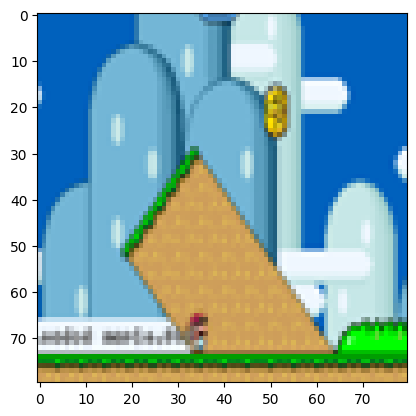

In [5]:
camera.set_foreground_game()
frame = camera.get_frame()
plt.imshow(frame)
frame.shape

### Agent

In [6]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [7]:
import gymnasium

# Register the custom environment with Gym
from gymnasium.envs.registration import register

register(
    id='CustomGameEnv-v0',
    entry_point='src.gamenv.gameenv:GameEnv',
    max_episode_steps=None,  # Adjust as needed
)

# Create the environment
# env = gymnasium.make('CustomGameEnv-v0')

# obs = env.reset()
# for _ in range(500):  # Adjust as needed
#     action = env.action_space.sample()  # Replace with your RL agent's action
#     obs, reward, done, truncated, info = env.step(action)
#     env.render()
#     if done or truncated:
#         obs = env.reset()
# env.close()

In [8]:
import gymnasium
import numpy as np
from gymnasium import spaces

env = gymnasium.make('CustomGameEnv-v0')
n_stack = 30  # Number of frames to stack

class FrameStackingWrapper(gymnasium.Wrapper):
    def __init__(self, env, n_stack=4):
        super(FrameStackingWrapper, self).__init__(env)
        self.n_stack = n_stack
        self.frames = np.zeros((n_stack, *env.observation_space.shape), dtype=np.uint8)
        
        self.observation_space = spaces.Box(low=0, high=255, shape=(n_stack, 80, 80, 3), dtype=np.uint8)

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.frames = np.zeros((self.n_stack, *self.env.observation_space.shape), dtype=np.uint8)
        for i in range(self.n_stack):
            self.frames[i] = obs
        stacked_obs = np.array(self.frames)
        return stacked_obs, info

    def step(self, action):
        obs, reward, done, truncated, info = self.env.step(action)
        self.frames[:-1] = self.frames[1:]  # Shift frames
        self.frames[-1] = obs  # Add new frame
        stacked_obs = np.array(self.frames)
        return stacked_obs, reward, done, truncated, info


c:\my tools\environments\pytorch_2_1_0_cuda_11_8\Lib\site-packages\gymnasium\envs\registration.py:481: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes']
  logger.warn(


In [9]:
import torch
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env.vec_frame_stack import VecFrameStack

env = FrameStackingWrapper(env, n_stack=n_stack)

In [10]:
import gym
import torch as th
import torch.nn as nn
import torch.nn.functional as F

from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor


class CustomCNN(BaseFeaturesExtractor):
    """
    :param observation_space: (gym.Space)
    :param features_dim: (int) Number of features extracted.
        This corresponds to the number of unit for the last layer.
    """

    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 256):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        # We assume CxHxW images (channels first)
        # Re-ordering will be done by pre-preprocessing or wrapper
        n_input_channels = observation_space.shape[-1]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with th.no_grad():
            n_flatten = self.cnn(
                th.as_tensor(observation_space.sample()).permute(0,3,1,2).float()
            ).shape[1]
        self.lstm = nn.LSTM(input_size=n_flatten, hidden_size=features_dim, num_layers=1, batch_first=True)

        self.linear = nn.Sequential(
            nn.Linear(features_dim, features_dim),
            nn.ReLU()
        )

    def forward(self, observations: th.Tensor) -> th.Tensor:
        x = observations.permute(0,1,4,2,3)
        batch_size, seq_len, c, h, w = x.size()

        x = observations.view(batch_size * seq_len, c, h, w)
        cnn_out = self.cnn(x)
        cnn_out = cnn_out.view(batch_size, seq_len, -1)
        lstm_out, (h_n, c_n) = self.lstm(cnn_out)
        lstm_out = F.relu(lstm_out[:,-1,:])
        return self.linear(lstm_out)

policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=256),
)

model = PPO('MlpPolicy', env, verbose=2,
            learning_rate=5e-3,
            n_steps=1048,
            batch_size=64, 
            clip_range=0.2, 
            max_grad_norm=0.5,
            tensorboard_log="./ppo_super_mario_tensorboard/",
            policy_kwargs=policy_kwargs,
)



Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\my tools\environments\pytorch_2_1_0_cuda_11_8\Lib\site-packages\stable_baselines3\ppo\ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1048`, after every 16 untruncated mini-batches, there will be a truncated mini-batch of size 24
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1048 and n_envs=1)
  warnings.warn(


In [11]:
model.policy

ActorCriticPolicy(
  (features_extractor): CustomCNN(
    (cnn): Sequential(
      (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Flatten(start_dim=1, end_dim=-1)
    )
    (lstm): LSTM(4096, 256, batch_first=True)
    (linear): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
    )
  )
  (pi_features_extractor): CustomCNN(
    (cnn): Sequential(
      (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Flatten(start_dim=1, end_dim=-1)
    )
    (lstm): LSTM(4096, 256, batch_first=True)
    (linear): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
    )
  )
  (vf_features_extractor): CustomCNN(
    (cnn): Sequential(
      (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))

In [12]:
from stable_baselines3.common.callbacks import BaseCallback

class BeforeTrainingCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(BeforeTrainingCallback, self).__init__(verbose)

    def _on_step(self) -> bool:
        # This method needs to be implemented but can remain empty if not needed
        return True

    def _on_rollout_end(self) -> None:
        # This method is called before the training process starts after n_steps
        print("Rollout has ended, training is about to start.")
        env.toggle_pause()
    
    def _on_rollout_start(self) -> None:
        print("Training has ended!")
        env.toggle_pause()

# Create the callback
callback = BeforeTrainingCallback()

In [13]:
# Train the model with the custom callback
model.learn(total_timesteps=50000, callback=callback)

Logging to ./ppo_super_mario_tensorboard/PPO_61
Training has ended!


c:\my tools\environments\pytorch_2_1_0_cuda_11_8\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.toggle_pause to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.toggle_pause` for environment variables or `env.get_wrapper_attr('toggle_pause')` that will search the reminding wrappers.
  logger.warn(


Rollout has ended, training is about to start.
-----------------------------
| time/              |      |
|    fps             | 34   |
|    iterations      | 1    |
|    time_elapsed    | 30   |
|    total_timesteps | 1048 |
-----------------------------
Training has ended!
Rollout has ended, training is about to start.
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 515         |
|    ep_rew_mean          | 1.77        |
| time/                   |             |
|    fps                  | 27          |
|    iterations           | 2           |
|    time_elapsed         | 75          |
|    total_timesteps      | 2096        |
| train/                  |             |
|    approx_kl            | 0.010054373 |
|    clip_fraction        | 0.265       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.18       |
|    explained_variance   | -0.0213     |
|    learning_rate        | 0.005       |
|   

Exception: mario - Snes9x 1.62.3 cannot be minimized.

In [ ]:
model.policy

ActorCriticPolicy(
  (features_extractor): CustomCNN(
    (cnn): Sequential(
      (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Flatten(start_dim=1, end_dim=-1)
    )
    (lstm): LSTM(4096, 256, batch_first=True)
    (linear): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
    )
  )
  (pi_features_extractor): CustomCNN(
    (cnn): Sequential(
      (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Flatten(start_dim=1, end_dim=-1)
    )
    (lstm): LSTM(4096, 256, batch_first=True)
    (linear): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
    )
  )
  (vf_features_extractor): CustomCNN(
    (cnn): Sequential(
      (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))

In [ ]:

# Retrieve the environment
# env = model.get_env()
# Train the agent
# model.learn(total_timesteps=100000)
# Save the agent

model.save("model")
# the policy_kwargs are automatically loaded

Logging to ./ppo_super_mario_tensorboard/PPO_60
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 151      |
|    ep_rew_mean     | -5       |
| time/              |          |
|    fps             | 31       |
|    iterations      | 1        |
|    time_elapsed    | 33       |
|    total_timesteps | 1048     |
---------------------------------


KeyboardInterrupt: 